In [1]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib.pyplot as plt

from data import cfg_mnet
from utils.prior_box import PriorBox
from utils.box_utils import decode, decode_landm, py_cpu_nms

In [2]:
def preprocess(img, input_size):
    """Preprocess an image before TRT retinaface inferencing.

    # Args
        img: uint8 numpy array of shape (img_h, img_w, 3)
        input_size: model input size

    # Returns
        preprocessed img: float32 numpy array of shape (3, H, W)
    """
    img = np.float32(img)
    img -= (104, 117, 123)
    height, width, _ = img.shape
    long_side = max(height, width)
    img_pad = np.zeros((long_side, long_side, 3), dtype=img.dtype)
    img_pad[0:0+height, 0:0+width] = img
    img = cv2.resize(img_pad, (input_size, input_size))
    img = img.transpose((2, 0, 1))
    return img

In [3]:
def postprocess(loc, conf, landms, priors, cfg, img):
    """Postprocess TensorRT outputs.

    # Args
        loc: [x, y, w, h]
        conf: [not object confidence, object confidence]
        landms: [eye_left.x, eye_left.y, 
                 eye_right.x, eye_right.y,
                 nose.x, nose.y
                 mouth_left.x, mouth_right.y
                 mouth_left.x, mouth_right.y]
        priors: priors boxes
        cfg: model parameter configure
        img: input image

    # Returns
        facePositions, landmarks (after NMS)
    """
    long_side = max(img.shape)
    img_size = cfg['image_size']
    variance = cfg['variance']
    scale = np.ones(4)*img_size
    scale1 = np.ones(10)*img_size
    confidence_threshold = 0.2
    top_k = 50
    nms_threshold = 0.5

    # decode boxes
    boxes = decode(np.squeeze(loc, axis=0), priors, variance)
    boxes = boxes*scale

    # decode landmarks
    landms = decode_landm(np.squeeze(landms, axis=0), priors, variance)
    landms = landms*scale1  

    # ignore low scores
    scores = np.squeeze(conf, axis=0)[:, 1]
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]   

    # keep top-K before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS 
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    dets = dets[keep, :]
    landms = landms[keep]
    
    # resize
    res = long_side/img_size
    facePositions = (dets[:,:4]*res).astype(int).tolist()
    landmarks = (landms*res).astype(int).tolist()
    return facePositions, landmarks

In [4]:
cfg = cfg_mnet
input_size = cfg['image_size']
priorbox = PriorBox(cfg, (input_size, input_size))
priors = priorbox.forward()
img_path = 'test/MaYingJeou_TsaiIngWen_SoongChuYu-test.png'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_resized = preprocess(img, input_size)
inputs = img_resized[np.newaxis, :, :, :]

In [5]:
onnx_path = "retinaface/retinaface-320.onnx"
detector = rt.InferenceSession(onnx_path)

In [6]:
for input in detector.get_inputs():
    input_name = input.name
    print("input name", input_name)
    input_shape = input.shape
    print("input shape", input_shape)
    input_type = input.type
    print("input type", input_type)
    print('-----------------------------')

input name input0
input shape [1, 3, 320, 320]
input type tensor(float)
-----------------------------


In [7]:
for output in detector.get_outputs():
    output_name = output.name
    print("output name", output_name)
    output_shape = output.shape
    print("output shape", output_shape)
    output_type = output.type
    print("output type", output_type)
    print('-----------------------------')

output name output0
output shape [1, 4200, 4]
output type tensor(float)
-----------------------------
output name 590
output shape [1, 4200, 2]
output type tensor(float)
-----------------------------
output name 589
output shape [1, 4200, 10]
output type tensor(float)
-----------------------------


In [8]:
inname = [input.name for input in detector.get_inputs()][0]
outname = [output.name for output in detector.get_outputs()]

In [9]:
loc, conf, landms = detector.run(outname, {inname: inputs})
facePositions, landmarks = postprocess(loc, conf, landms, priors, cfg, img)

(-0.5, 709.5, 524.5, -0.5)

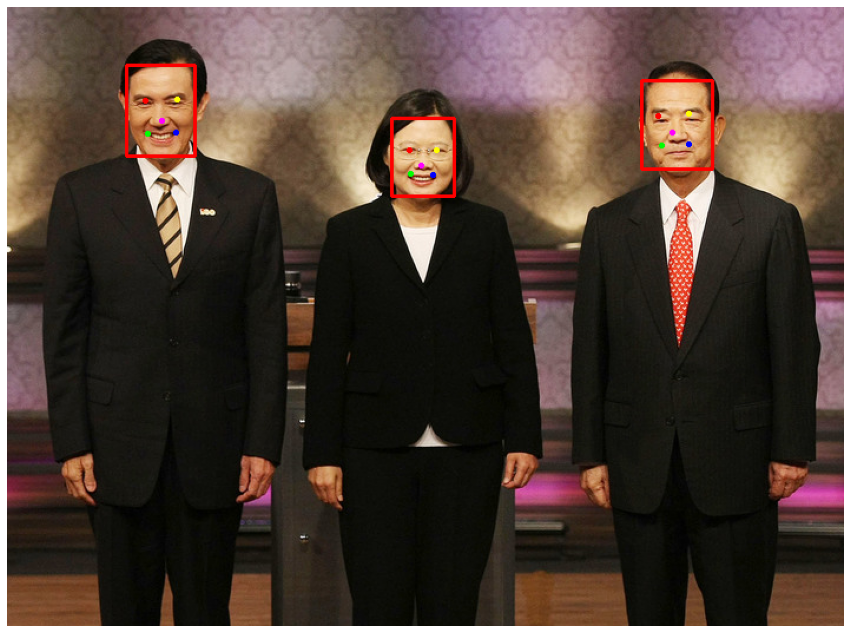

In [10]:
for (x1, y1, x2, y2), landmark in zip(facePositions, landmarks):
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.circle(img, (landmark[0], landmark[1]), 1, (0, 0, 255), 2)
    cv2.circle(img, (landmark[2], landmark[3]), 1, (0, 255, 255), 2)
    cv2.circle(img, (landmark[4], landmark[5]), 1, (255, 0, 255), 2)
    cv2.circle(img, (landmark[6], landmark[7]), 1, (0, 255, 0), 2)
    cv2.circle(img, (landmark[8], landmark[9]), 1, (255, 0, 0), 2)
plt.figure(figsize=(15, 20))
plt.imshow(img[:, :, ::-1]/255)
plt.axis('off')